In [31]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import glob
import pandas as pd
from torchvision import models
import torch.nn as nn
from fastai.vision import Path
import torch
from torch.autograd import Variable
%matplotlib inline 
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

print(os.listdir("../input"))
train_dataset_path = "../input/captcha-dataset-v2/samples"
test_dataset_path = "../input/captcha-dataset/samples"
files = glob.glob(test_dataset_path+ "/**/*.jpg")
file_count = len(files)
print(file_count)
#print(file_count, "samples found")

['jcaptchasamples', 'captcha-dataset', 'captcha-dataset-v2']
100000


In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
#ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET = NUMBER
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 4

In [3]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [4]:
class Mydataset(Dataset):
    def __init__(self, path,transform=None):
        self.path = path
        self.img = glob.glob(path+"/**/*.jpg")
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(img_path)
        img = img.convert('L')
        #label = Path(self.path/img_path).name[:-4]
        label = os.path.basename(os.path.dirname(img_path))
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [5]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [6]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [34]:

valid_size = 0.2

batch_size = 64

train_data = Mydataset(train_dataset_path, transform)
test_data = Mydataset(test_dataset_path, transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
test_loader = DataLoader(test_data, batch_size=1, num_workers=0)

In [10]:
model = models.resnet18(pretrained=False)

In [11]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [12]:
model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)

In [13]:
model.cuda();

In [14]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:

def train():
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    n_epochs = 10    
    early_stopping = EarlyStopping(patience=5, verbose=True)
    for epoch in range(1, n_epochs+ 1):   
        model.train()
        for step, i in enumerate(train_loader):
            img, label_oh, label = i
            img = Variable(img).cuda()
            label_oh = Variable(label_oh.float()).cuda()
            pred = model(img)
            loss = loss_func(pred, label_oh)
            optm.zero_grad()
            loss.backward()
            optm.step()
            train_losses.append(loss.item())
            print('eopch:', epoch, 'step:', step+1,'/',len(train_loader), 'loss:', loss.item(),  end="\r")
        model.eval() # prep model for evaluation
        for step, i in  enumerate(valid_loader):
            img, label_oh, label = i
            img = Variable(img).cuda()
            label_oh = Variable(label_oh.float()).cuda()
            pred = model(img)
            loss = loss_func(pred, label_oh)
            valid_losses.append(loss.item())   
            
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)  

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)
        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('model.pt'))
    return  model, avg_train_losses, avg_valid_losses

model, train_loss, valid_loss = train()

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [19]:
model.load_state_dict(torch.load('model.pt'))
model.eval();

ValueError: num must be 1 <= num <= 20, not 21

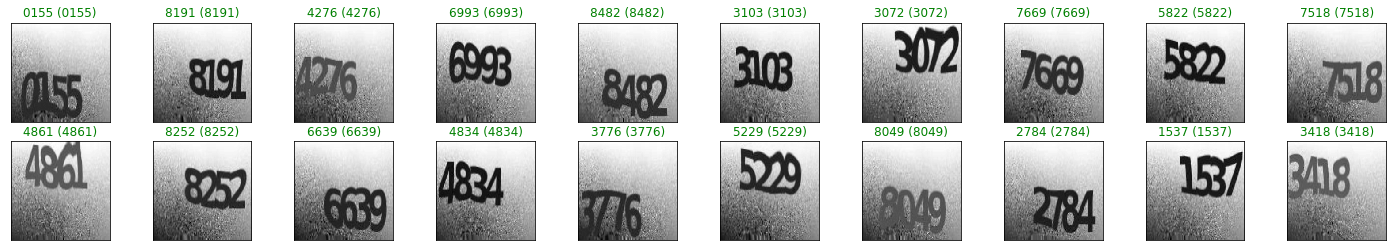

In [39]:

def val_prediction(preds):
    pred = preds.squeeze().cpu().tolist()
    c0 = ALL_CHAR_SET[np.argmax(pred[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(pred[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(pred[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    #c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    return '%s%s%s%s' % (c0, c1, c2, c3)    
    
dataiter = iter(valid_loader)
images, _, labels = dataiter.next()

model.load_state_dict(torch.load('checkpoint.pt'))

images = Variable(images).cuda()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
preds = [val_prediction(x) for x in output]
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(40):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [38]:

s=1
t=len(test_loader.dataset)
for step, (img, label_oh, label) in enumerate(test_loader):
    img = Variable(img).cuda()
    preds = model(img)
    pred = preds.squeeze().cpu().tolist()
    c0 = ALL_CHAR_SET[np.argmax(pred[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(pred[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(pred[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    #c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    c = '%s%s%s%s' % (c0, c1, c2, c3)
    if c == label[0]:
        s= s + 1
print(round((s/t)*100),'%')
   

100 %


In [ ]:

files = glob.glob("../input/jcaptchasamples/samples/*.jpg")
t=len(files)
c=1
for file in files: 
    pr,acc=predict_file(file)
    label = os.path.basename(file)[:4]
    if pr==label:
        c=c+1
print(round((c/t)*100),'%')